<a href="https://colab.research.google.com/github/mdaugherity/MachineLearning2024/blob/main/tutorial/Tutorial_14_Neural_Networks.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Dr. Daugherity, PHYS 453**

# Tutorial 14: NEURAL NETWORKS!

Finally, its time to take over the world.

References:
* User's Guide - http://scikit-learn.org/stable/modules/neural_networks_supervised.html
* API - http://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPClassifier.html

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn import datasets
from sklearn import preprocessing
from sklearn import neural_network

---
# Simple Example

Load some 2D Iris data that we have used before

In [2]:
X,y = datasets.load_iris(return_X_y=True)
X = X[50:,[2,0]]  # only save features 2 and 0; species 1 and 2
y = y[50:]-1

Training a neural network is easy as $\pi$.  Parameters to adjust:
* **hidden_layer_sizes** : tuple, defaults to (100) so you definitely want to set your own
* **max_iter (default=200)** : crank this up if it isn't converging
* **random_state** : set to a value if you want repeatable results
* **activation{‘identity’, ‘logistic’, ‘tanh’, ‘relu’}, default=’relu’** : logistic is good if everything is between 0 and 1, tanh can be slower but more stable than relu


Read the documentation for more

In [3]:
clf = neural_network.MLPClassifier(hidden_layer_sizes=(5),max_iter=1000, random_state=42)
clf.fit(X,y)

MLPClassifier(hidden_layer_sizes=5, max_iter=1000, random_state=42)

In [4]:
def plot_decision(clf, X, cmap='coolwarm', h=0.2, margin=0.2, alpha=0):
    """Plots decision boundary of clf.  X is only used to find min/max range; h = grid size; margin = extra border padding"""
    x_min, x_max = X[:, 0].min()-margin, X[:, 0].max()+margin
    y_min, y_max = X[:, 1].min()-margin, X[:, 1].max()+margin
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    #plt.pcolormesh(xx, yy, Z, cmap=cmap, alpha=alpha)
    plt.contourf(xx, yy, Z, cmap=cmap, alpha=alpha)

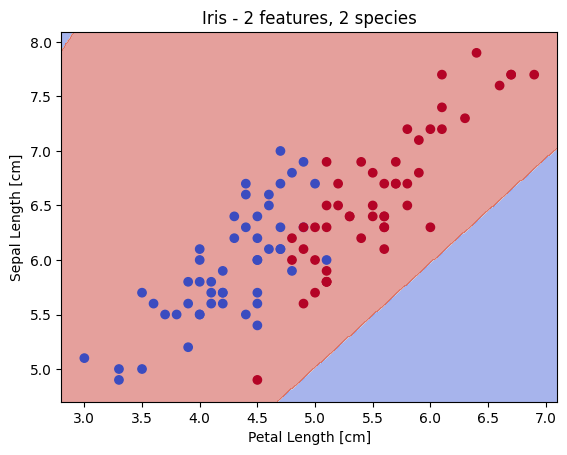

In [5]:
plt.figure()
plot_decision(clf,X,h=0.01,alpha=0.5)
plt.scatter(X[:,0], X[:,1], c=y, cmap=plt.cm.coolwarm)
plt.title('Iris - 2 features, 2 species')
plt.xlabel('Petal Length [cm]')
plt.ylabel('Sepal Length [cm]')
plt.show()

In [6]:
clf.score(X,y)

0.5

Aaaaand that failed miserably.  Are you impressed with neural networks yet?  

Well, some of that is our fault.  Like with linear models and several other classifiers **WE NEED TO SCALE THE DATA FIRST!!!!!**.  Neural networks like standardized data, and the easiest way to do that is to use sklearn's StandardScaler to rescale each feature to have a mean of 0 and variance of 1.  

# Standard Scaler

In [7]:
X.mean(axis=0)  # original means of each feature

array([4.906, 6.262])

In [8]:
scaler = preprocessing.StandardScaler()
scaler.fit(X)
print(scaler.mean_)

[4.906 6.262]


In [9]:
X_scale = scaler.transform(X)
X_scale.mean(axis=0)

array([ 3.26960681e-16, -6.68354261e-16])

Like with classifiers, scalers get `fit` to the data.  Then they can `transform` any point.  There is also a combined `fit_transform` method that does both.  Let's see what happens....

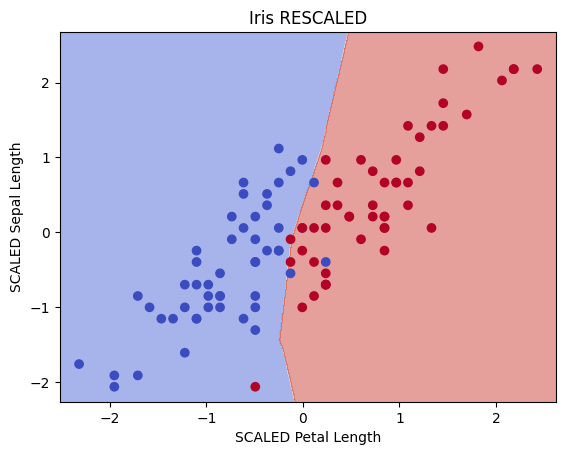

In [10]:
clf = neural_network.MLPClassifier(hidden_layer_sizes=(5),max_iter=10000, random_state=42)
clf.fit(X_scale,y)
plt.figure()
plot_decision(clf,X_scale,h=0.01,alpha=0.5)
plt.scatter(X_scale[:,0], X_scale[:,1], c=y, cmap=plt.cm.coolwarm)
plt.title('Iris RESCALED')
plt.xlabel('SCALED Petal Length')
plt.ylabel('SCALED Sepal Length')
plt.show()

In [11]:
clf.score(X_scale, y)

0.94

One final lesson before the main event.  Remember that neural networks are doing a **search** to find that weights that minimize the loss function.  It is often very helpful to look at the **learning curve** showing how the loss function changes with each iteration.

In [12]:
clf.loss_curve_[-5:]

[0.161156564534712,
 0.16105892832890695,
 0.16096201388803594,
 0.1608649758105095,
 0.160767851593692]

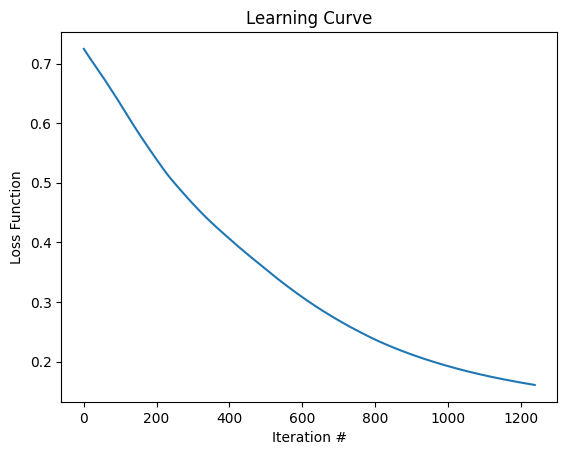

In [13]:
plt.figure()
plt.plot(clf.loss_curve_)
plt.title('Learning Curve')
plt.xlabel('Iteration #')
plt.ylabel('Loss Function')
plt.show()

***
In this example, I will generate and load some datasets to explore what happens when we vary the number of hidden nodes and layers.
Pay attention to how the shape of the decision boundary becomes more complex.

# Input Data



In [14]:
# Generate a few datasets to play with
# have to make some modifications to get 2 classes
Xcircle, ycircle = datasets.make_circles()

num_clust = 20
Xclust,yclust = datasets.make_blobs(n_samples=10*num_clust,centers=num_clust,random_state=42)
yclust = np.floor_divide(yclust,num_clust/2) # default is one class per blob, this changes it to 2 classes

Xmoons, ymoons = datasets.make_moons()

Xblobs, yblobs = datasets.make_blobs(n_samples=100,centers=2,random_state=42,cluster_std=4)

# listify
Xdata = (Xblobs,Xclust,Xmoons,Xcircle)
ydata = (yblobs,yclust,ymoons,ycircle)

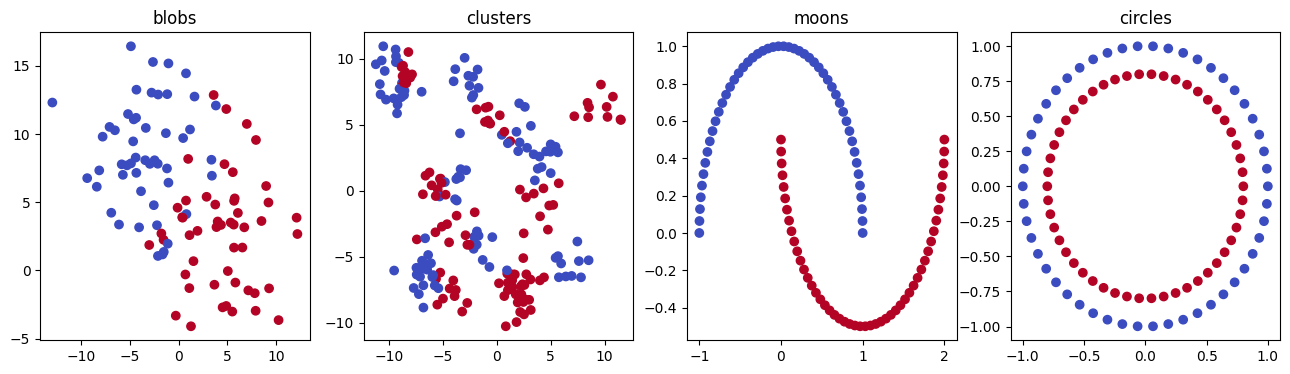

In [15]:
plt.figure(figsize=(16,4))

titles = ('blobs','clusters','moons','circles')
for i,(X,y,title) in enumerate(zip(Xdata,ydata,titles)):
    plt.subplot(1,4,i+1)
    X0 = X[:,0]
    X1 = X[:,1]
    plt.scatter(X0, X1,c=y,cmap='coolwarm')
    plt.title(title)

plt.show()

***
# Using Neural Networks

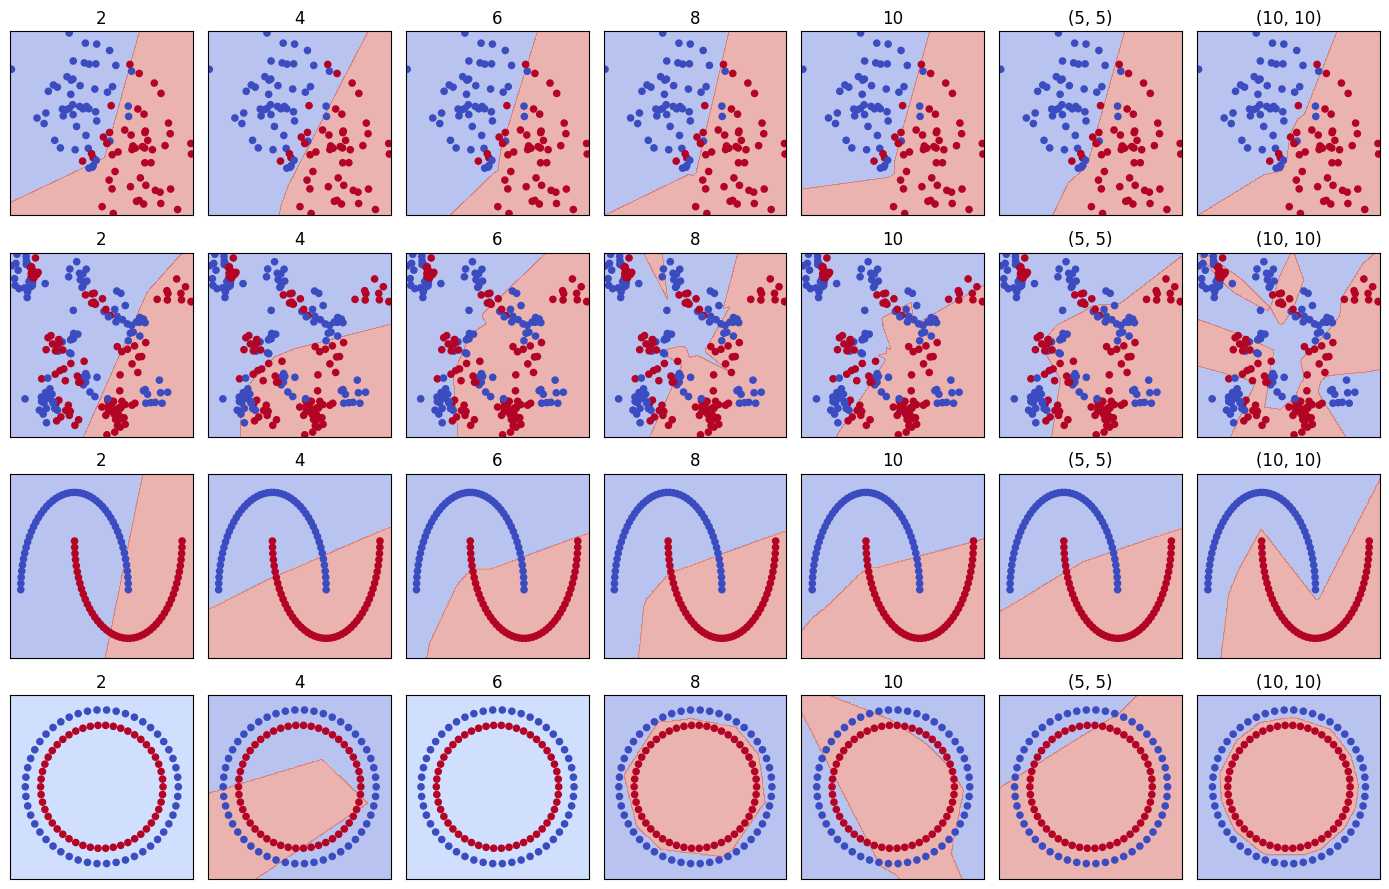

In [16]:
hiddens = ((2),(4),(6),(8),(10),(5,5),(10,10))  # list of hidden layers/nodes to try

plt.figure(figsize=(14,9))

for i,(X,y) in enumerate(zip(Xdata,ydata)):
    X0 = X[:,0]
    X1 = X[:,1]

    for j,hidden in enumerate(hiddens):
        ax = plt.subplot(len(Xdata),len(hiddens),len(hiddens)*i+1+j)
        ax.set_title(hidden)
        ax.set_xticks(())
        ax.set_yticks(())
        clf = neural_network.MLPClassifier(hidden_layer_sizes=hidden,max_iter=10000,random_state=42)
        clf.fit(X,y)
        #plot_contours(ax,clf,xx,yy,cmap='coolwarm',alpha=0.4)
        plot_decision(clf,X,h=0.01, alpha=0.4)
        plt.scatter(X0, X1, s=20, c=y,cmap='coolwarm')

plt.tight_layout()
plt.show()